# Pytorch dijk profile net + test code

## Imports

In [1]:
# imports
from __future__ import print_function, division
import numpy as np
# import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import torch.nn.functional as F
import csv
import torch
import torch.nn as nn
from tqdm.autonotebook import tqdm
from tqdm import tqdm_notebook
import time
import pickle
from sklearn.preprocessing import StandardScaler
import os
import torch
import pandas as pd
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from operator import itemgetter

from torch.nn.functional import sigmoid
from torch.autograd import Variable
from PIL import Image
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


/data/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Network architecture

In [2]:
# construct the network

class Double_conv(nn.Module):

    '''(conv => ReLU) * 2 => MaxPool2d'''

    def __init__(self, in_ch, out_ch, p):
        """
        Args:
            in_ch(int) : input channel
            out_ch(int) : output channel
        """
        super(Double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, 3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 5, padding=2, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 7, padding=3, stride=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=p)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class Conv_down(nn.Module):

    '''(conv => ReLU) * 2 => MaxPool2d'''

    def __init__(self, in_ch, out_ch, p):
        """
        Args:
            in_ch(int) : input channel
            out_ch(int) : output channel
        """
        super(Conv_down, self).__init__()
        self.conv = Double_conv(in_ch, out_ch, p)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.conv(x)
        pool_x = self.pool(x)
        return pool_x, x


class Conv_up(nn.Module):

    '''(conv => ReLU) * 2 => MaxPool2d'''

    def __init__(self, in_ch, out_ch, p):
        """
        Args:
            in_ch(int) : input channel
            out_ch(int) : output channel
        """
        super(Conv_up, self).__init__()
        self.up = nn.ConvTranspose1d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = Double_conv(in_ch, out_ch, p)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1_dim = x1.size()[2]
        x2 = extract_img(x1_dim, x2)
        x1 = torch.cat((x1, x2), dim=1)
        x1 = self.conv(x1)
        return x1


def extract_img(size, in_tensor):
    """
    Args:
        size(int) : size of cut
        in_tensor(tensor) : tensor to be cut
    """
    dim1 = in_tensor.size()[2]
    in_tensor = in_tensor[:, :, int((dim1-size)/2):int((size + (dim1-size)/2))]
    return in_tensor


class Dijknet(nn.Module):
    def __init__(self, in_channels, out_channels, p=0.25):
        super(Dijknet, self).__init__()
        self.Conv_down1 = Conv_down(in_channels, 64, p)
        self.Conv_down2 = Conv_down(64, 128, p)
        self.Conv_down3 = Conv_down(128, 256, p)
        self.Conv_down4 = Conv_down(256, 512, p)
        self.Conv_down5 = Conv_down(512, 1024, p)
        self.Conv_up1 = Conv_up(1024, 512, p)
        self.Conv_up2 = Conv_up(512, 256, p)
        self.Conv_up3 = Conv_up(256, 128, p)
        self.Conv_up4 = Conv_up(128, 64, p)
        self.Conv_up5 = Conv_up(128, 64, p)
        self.Conv_out = nn.Conv1d(64, out_channels, 1, padding=0, stride=1)
        self.Conv_final = nn.Conv1d(out_channels, out_channels, 1, padding=0, stride=1)
        
#         self.Conv_down1 = Conv_down(in_channels, 8)
#         self.Conv_down2 = Conv_down(8, 16)
#         self.Conv_down3 = Conv_down(16, 32)
#         self.Conv_down4 = Conv_down(32, 64)
#         self.Conv_down5 = Conv_down(64, 128)
#         self.Conv_up1 = Conv_up(128, 64)
#         self.Conv_up2 = Conv_up(64, 32)
#         self.Conv_up3 = Conv_up(32, 16)
#         self.Conv_up4 = Conv_up(16, 8)
#         self.Conv_up5 = Conv_up(16, 8)
#         self.Conv_out = nn.Conv1d(8, out_channels, 1, padding=0, stride=1)
#         self.Conv_final = nn.Conv1d(out_channels, out_channels, 1, padding=0, stride=1)

    def forward(self, x):
        input_image = x
#         print("input shape: {}".format(x.shape))
        x, conv1 = self.Conv_down1(x)
#         print("dConv1 => down1|", x.shape)
        x, conv2 = self.Conv_down2(x)
#         print("dConv2 => down2|", x.shape)
        x, conv3 = self.Conv_down3(x)
#         print("dConv3 => down3|", x.shape)
        x, conv4 = self.Conv_down4(x)
#         print("dConv4 => down4|", x.shape)
        _, x = self.Conv_down5(x)
#         print("dConv5|", x.shape)
        x = self.Conv_up1(x, conv4)
#         print("up1 => uConv1|", x.shape)
        x = self.Conv_up2(x, conv3)
#         print("up2 => uConv2|", x.shape)
        x = self.Conv_up3(x, conv2)
#         print("up3 => uConv4|", x.shape)
        x = self.Conv_up4(x, conv1)
#         print("up4 => final|", x.shape)
        # final upscale to true size
#         x = self.Conv_up5(x, input_image)
        x = self.Conv_out(x)
        x = self.Conv_final(x)
        return x

print("done!")

done!


## conversion dicts for the csv inpute files. maps names to classnumbers

In [3]:
# construct various dicts to convert the original data to a usable format

ben_conversion_dict = {
    "": "leeg",
    "101_Q19_2" : "buitenkruin",
    "101_Q19_3" : "binnenkruin",
    "101_Q19_5" : "binnenteen",
    "105_T09_11": "insteek_sloot",
    "811_T13_8" : "leeg",
    "351_T03_10" : "leeg",
    "_T01_KKW" : "leeg",
    "108_Q06_250" : "leeg",
    "303_Q05_1": "leeg",
    "353__11" : "leeg",
    "_T00_17" : "leeg",
    "109_Q08_13" : "leeg",
    "_Q07_KDM" : "leeg",
    "_Q07_KDW" : "leeg",
    
    '0' : "leeg",
    None : "leeg",
    'nan' : "leeg"
}
class_dict_regionaal = {
    "leeg": 0,
    "startpunt": 1,
    "buitenkruin": 2,
    "binnenkruin": 3,
    "binnenteen": 4,
    "insteek_sloot": 5
}

class_dict = {
    'leeg': 0,
    'Maaiveld binnenwaarts': 1,
    'Insteek sloot polderzijde': 2,
    'Slootbodem polderzijde': 3,
    'Slootbodem dijkzijde': 4,
    'Insteek sloot dijkzijde': 5,
    'Teen dijk binnenwaarts': 6,
    'Kruin binnenberm': 7,
    'Insteek binnenberm': 8,
    'Kruin binnentalud': 9,
    'Verkeersbelasting kant binnenwaarts': 9, # 10
    'Verkeersbelasting kant buitenwaarts': 10,
    'Kruin buitentalud': 10, #12
    'Insteek buitenberm': 11,
    'Kruin buitenberm': 12,
    'Teen dijk buitenwaarts': 13,
    'Insteek geul': 14,
    'Teen geul': 15,
    'Maaiveld buitenwaarts': 16,
}

# set the class dict to either the full class_dict for non-regional keringen (leave it)
# or set it to the smaller dict for regional keringen by uncommenting this line

# class_dict = class_dict_regionaal
inverse_class_dict = {v: k for k, v in class_dict.items()}

# manual mappings to get the correct names for plotting later
if "11" in inverse_class_dict:
    inverse_class_dict["10"] = 'Kruin buitentalud'


In [4]:
# read regional keringen data suplied by Ben Keuenen

# pro1 = pd.read_csv('ben_regionale_keringen/RWK_Profielen_B1.csv', sep=';')
# pro2 = pd.read_csv('ben_regionale_keringen/RWK_Profielen_B2.csv', sep=';')
# pro3 = pd.read_csv('ben_regionale_keringen/RWK_Profielen_B3.csv', sep=';')
# pro4 = pd.read_csv('ben_regionale_keringen/RWK_Profielen_B4.csv', sep=';')
# reg_keringen_ENTRIES = pd.concat([pro1,pro2,pro3,pro4])
# # print(reg_keringen_ENTRIES)
# reg_keringen_ENTRIES.head()

## Read regular dijk profiles, transform and save to pickle

In [5]:
# source_surfacelines = 'surfacelines_beter.csv'
# source_characteristicpoints = 'characteristicpoints_beter.csv'

source_surfacelines = 'dijkprofiles_fryslan/2-2/surfacelines.csv'
source_characteristicpoints = 'dijkprofiles_fryslan/2-2/characteristicpoints.csv'

annotation_tuples = [
#     ('dijkprofiles_fryslan/2-2/surfacelines.csv', 'dijkprofiles_fryslan/2-2/characteristicpoints.csv'),
#     ('dijkprofiles_fryslan/6-3/surfacelines.csv', 'dijkprofiles_fryslan/6-3/characteristicpoints.csv'),
#     ('dijkprofiles_fryslan/6-4/surfacelines.csv', 'dijkprofiles_fryslan/6-4/characteristicpoints.csv'),
    ('dijkprofielen_13-4_primair/surfacelines.csv', 'dijkprofielen_13-4_primair/characteristicpoints.csv'),
    ('surfacelines_beter.csv', 'characteristicpoints_beter.csv')
]

# utility function
def ffill(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[1]), 0)
    np.maximum.accumulate(idx, axis=1, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

profile_dict = {}
surfaceline_dict_total = {}
for source_surfacelines, source_characteristicpoints in annotation_tuples:
    surfaceline_dict = {}
    
    # read the coordinates and collect to surfaceline_dict
    with open(source_surfacelines) as csvfile:
        surfacereader = csv.reader(csvfile, delimiter=';', quotechar='|')
        header = next(surfacereader)
        print("header: {}".format(header)) # not very useful
        for row in surfacereader:
            location = row[0]
            surfaceline_dict[location] = []
            for i in range(1, len(row)-2, 3):
                x = float(row[i])
                y = float(row[i+1])
                z = float(row[i+2])
                surfaceline_dict[location].append((x,y,z))

    print("loaded surfacelines for {} locations".format(len(surfaceline_dict.keys())))

    cpoints_dict = {}
    # read the characteristicpoints and save to cpoints_dict
    with open(source_characteristicpoints) as csvfile:
        cpointsreader = csv.reader(csvfile, delimiter=';', quotechar='|')
        header = next(cpointsreader)
        for row in cpointsreader:
            location = row[0]
            point_dict = {}
            for i in range(1, len(row)-2, 3):
                x = float(row[i])
                y = float(row[i+1])
                z = float(row[i+2])

                point_dict[header[i][2:]] = (x,y,z)
            cpoints_dict[location] = point_dict

    print("loaded characteristic points for {} locations".format(len(cpoints_dict.keys())))

    # transform the data to a usable format, save to profile_dict
    X_samples_list = []
    Y_samples_list = []
    location_list = []
    for location in surfaceline_dict.keys():
        heights = np.array(surfaceline_dict[location])[:,2].astype(np.float32)
        x_y_s = np.array(surfaceline_dict[location])[:,:2].astype(np.float32)
        labels = np.zeros(len(heights))
        for i, (key, point) in enumerate(cpoints_dict[location].items()):
            # if the point is not empty, find the nearest point in the surface file, 
            # rounding errors require matching by distance per point
            if point == (-1.0, -1.0, -1.0):
                continue

            distances = []
            for idx, surfacepoint in enumerate(surfaceline_dict[location]):
                dist = np.linalg.norm(np.array(surfacepoint)-np.array(point))
                distances.append((idx, dist))
            (idx, dist) = sorted(distances, key=itemgetter(1))[0]
            labels[idx] = class_dict[key]

        for i in range(1, len(labels)):
            if labels[i] == 0.0:
                labels[i] = labels[i-1]

        z_tmp = np.zeros(352)
        labels_tmp = np.zeros(352)
        profile_length = labels.shape[0]
        if profile_length < 352:
            z_tmp[:profile_length] = np.array(heights, dtype=np.float32)[:profile_length]
            labels_tmp[:profile_length] = np.array(labels)[:profile_length]
            z_tmp[profile_length:] = heights[profile_length-1]
            labels_tmp[profile_length:] = labels[profile_length-1]
            heights = z_tmp
            labels = labels_tmp
        else:
            heights = heights[:352]
            labels = labels[:352]
        
        profile_dict[location] = {}
        profile_dict[location]['profile'] = heights.astype(np.float32)
        profile_dict[location]['label'] = labels.astype(np.int32)
    
    for key, value in surfaceline_dict.items():
        surfaceline_dict_total[key] = value
    

outfile = open('keringen_dijk.pik', 'wb')
pickle.dump(profile_dict, outfile)
outfile.close()
outfile2 = open('surfaceline_dict.pik', 'wb')
pickle.dump(surfaceline_dict_total, outfile2)
outfile2.close()
print("done!")

header: ['LOCATIONID', 'X1', 'Y1', 'Z1', '.....', 'Xn', 'Yn', 'Zn', '(Profiel)']
loaded surfacelines for 454 locations
loaded characteristic points for 454 locations
header: ['LOCATIONID', 'X1', 'Y1', 'Z1', '.....', 'Xn', 'Yn', 'Zn', '(Profiel)']
loaded surfacelines for 822 locations
loaded characteristic points for 822 locations
done!


## read regional keringen and save to pickle

In [8]:
def is_df_sorted(df, colname):
    return pd.Index(df[colname]).is_monotonic

def ffill(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[1]), 0)
    np.maximum.accumulate(idx, axis=1, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

reg_keringen_profiles = {}

# profile_names = reg_keringen_ENTRIES['RFLNAAM'].unique()
files = glob.glob("ben_regionale_keringen/*.csv")

for filename in files:
    with open(filename) as csvfile:
        cpointsreader = csv.reader(csvfile, delimiter=';', quotechar='|')
        header = next(cpointsreader)
        lastlocation = None
        z = []
        label = []
        for i , row in enumerate(cpointsreader):
            location = row[0]
            if i == 0:
                lastlocation = location

            if location == lastlocation:
                label.append(str(row[4]))
                z.append(float(row[7].replace(',','.')))
            else:
                try:
                    label = [ben_conversion_dict[labelname] for labelname in label]
                    label = [class_dict_regionaal[labelcode] for labelcode in label]
                except:
                    print(label)
                label[0] = 1
                for i in range(1, len(label)):
                    if label[i] == 0.0:
                        label[i] = label[i-1]
                        
                z_tmp = np.zeros(256)
                labels_tmp = np.zeros(256)
                z_tmp[:150] = np.array(z, dtype=np.float32)[:150]
                labels_tmp[:150] = np.array(label)[:150]
                z_tmp[150:] = z[-1]
                labels_tmp[151:] = label[-1]

                reg_keringen_profiles[lastlocation] = {}
                reg_keringen_profiles[lastlocation]['profile'] = z_tmp.astype(np.float32)
                reg_keringen_profiles[lastlocation]['label'] = labels_tmp.astype(np.int32)
                lastlocation = location
                z = []
                label = []
            
print(len(reg_keringen_profiles))
outfile = open('reg_keringen.pik', 'wb')
pickle.dump(reg_keringen_profiles,outfile)
outfile.close()


21346


## Load profiles from dicts 

In [17]:
profile_dict = pickle.load(open('keringen_dijk.pik', 'rb'))
surfaceline_dict = pickle.load(open('surfaceline_dict.pik', 'rb'))

print("size of dataset: ", len(profile_dict))
randkey = np.random.choice(list(profile_dict.keys()))
print(profile_dict[randkey]['profile'].shape)
print(len(surfaceline_dict[randkey]))
print(profile_dict[randkey]['label'])

# print(surfaceline_dict[randkey][200])
# print(profile_dict[randkey]['profile'][200])

size of dataset:  2393
(352,)
346
[16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 13 13 13 13 13
 13 13 12 12 12 12 12 12 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 10 10 10 10 10  9  9  9  9  9  9  9  9  9  8  8  8  8  8
  8  8  8  8  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  

## Preprocess data/train scaler

In [18]:
accumulator = np.zeros((len(profile_dict), profile_dict[key]['profile'].shape[0]))

for i, key in enumerate(profile_dict.keys()):
    accumulator[i, :] = profile_dict[key]['profile']

scaler = StandardScaler()
scaler.fit(accumulator.reshape(-1, 1))

for i, key in enumerate(profile_dict.keys()):
    profile_dict[key]['profile'] = scaler.transform(profile_dict[key]['profile'].reshape(-1,1)).reshape(-1)
    
print("scaler params: ", scaler.scale_, scaler.mean_, scaler.var_, scaler.n_samples_seen_)

scaler params:  [11.34926616] [-3.5894847] [128.80584227] 842336


## split dataset

In [19]:
from torch.utils import data
from sklearn.model_selection import train_test_split
class DijkprofileDataset(data.Dataset):
    """Dijkprofile dataset."""
    
    def __init__(self, profile_dict, partition):
        'init'
        self.data_dict = profile_dict
#         self._mode = 'train'
        self.list_IDs = partition
    
#     def set_mode(self, mode):
#         "change mode of the dataset"
#         self._mode = mode
#         self.list_IDs = partition[self._mode]
    
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        X = self.data_dict[ID]['profile'].reshape(1,-1).astype(np.float32)
        y = self.data_dict[ID]['label'].reshape(1,-1)
        return X, y
    
    def __str__(self):
        return "<Dijkprofile dataset: datapoints={}>".format(len(self.list_IDs))

    
def get_loss_train(model, data_train, criterion):
    """
        Calculate loss over train set
    """
    model.eval()
    total_acc = 0
    total_loss = 0
    for batch, (images, masks) in enumerate(data_train):
        with torch.no_grad():
            images = Variable(images.cuda())
            masks = Variable(masks.cuda())
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = torch.argmax(outputs, dim=1).float()
            acc = accuracy_check_for_batch(masks.cpu(), preds.cpu(), images.size()[0])
            total_acc = total_acc + acc
            total_loss = total_loss + loss.cpu().item()
    return total_acc/(batch+1), total_loss/(batch + 1)


id_list = list(profile_dict.keys())
[train, test] = train_test_split(id_list, shuffle=True, test_size=0.2)

partition = {'train': train, 'validation': test}
dataset_train = DijkprofileDataset(profile_dict, train)
dataset_validation = DijkprofileDataset(profile_dict, test)
print(dataset_train)
print(dataset_validation)

<Dijkprofile dataset: datapoints=1914>
<Dijkprofile dataset: datapoints=479>


In [20]:
len(set(class_dict.values()))
# class_dict

17

In [22]:
from torch.utils import data

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# device = 'cpu'
# cudnn.benchmark = True

# Parameters
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 16}

params_val = {'batch_size': 512,
          'shuffle': True,
          'num_workers': 16}
max_epochs = 100

# Generators
training_generator = data.DataLoader(dataset_train, **params)
validation_generator = data.DataLoader(dataset_validation, **params_val)

model = Dijknet(1, len(set(class_dict.values())))

# if torch.cuda.device_count() > 1:
#     print("Using ", torch.cuda.device_count(), "GPUs!")

# model = nn.DataParallel(model)
model.to(device)
# model = torch.nn.DataParallel(model, device_ids=list(
#         range(torch.cuda.device_count())))

# loss
criterion = nn.CrossEntropyLoss()

# Optimizer
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Loop over epochs
for epoch in range(max_epochs):
    # Training
    loss_list = []
    for local_batch, local_labels in training_generator:
        if not local_labels.shape[0] == params['batch_size']:
            print('skipping an iteration due to batch size bug')
            continue
        
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device).long()

        # Model computations
        outputs = model(local_batch.to(device))
        local_labels = local_labels.reshape(params['batch_size'], -1)
#         print("local label shape", local_labels.shape)
#         print("outputs shape", outputs.shape)
#         print(local_labels)
#         print(outputs)
        loss = criterion(outputs, local_labels)
        
#         print(loss)
        optimizer.zero_grad()
        loss.backward()
        # Update weights
        optimizer.step()
        loss_list.append(loss.detach().cpu().numpy())

    print("loss: ", np.mean(loss_list))
    # Validation
    with torch.set_grad_enabled(False):
#         total = 0
        batch_accuracies = []
        for local_batch, local_labels in validation_generator:
            # Transfer to GPU
#             if not local_labels.shape[0] == params_val['batch_size']:
#                 print('skipping an iteration due to batch size bug')
#                 continue
                
            local_batch, local_labels = local_batch.to(device), local_labels.long()

            # Model computations
            outputs = model(local_batch)
            
#             outputs_round = torch.round(outputs).cpu()
            flat_output = torch.argmax(outputs, dim=1).cpu().reshape(local_batch.shape[0], 1, -1)
#             print("flat output: ", flat_output.shape)
            compare = flat_output == local_labels # maybe this works?
#             print("compare: ", compare.shape)
#             print("local_labels: ", local_labels.shape)
#             compare = flat_output[0] == local_labels[0]
#             print(compare)

            
    
            acc = np.sum(compare.numpy(), axis=2) / int(local_batch.shape[-1]) # * params_val['batch_size']
#             print("local acc: ", np.mean(acc, axis=0)[0])
            batch_accuracies.append(np.mean(acc, axis=0)[0])
#             _, predicted = torch.max(outputs.data, 1)
            
#         print(batch_accuracies)
        print("acc: {}".format(np.mean(batch_accuracies)))
#         print("local batch:")
#         print(local_batch[0])
#         print("local labels:")
#         print(local_labels[0])
#         print("outputs:")
#         print(flat_output[0])
#         print(flat_output[0].shape)
#     print('Accuracy of the network on the 10000 test images: %d %%' % (
#         100 * correct / total))            

skipping an iteration due to batch size bug
loss:  0.16950518
acc: 0.9531161036249762
skipping an iteration due to batch size bug
loss:  0.13183965
acc: 0.9541718067944582
skipping an iteration due to batch size bug
loss:  0.115762025
acc: 0.9537032643765421
skipping an iteration due to batch size bug
loss:  0.11119295
acc: 0.9524814955399507
skipping an iteration due to batch size bug
loss:  0.11354067
acc: 0.9534482349591953
skipping an iteration due to batch size bug
loss:  0.1137505
acc: 0.9547293129626114
skipping an iteration due to batch size bug
loss:  0.10848026
acc: 0.9558324634655533
skipping an iteration due to batch size bug
loss:  0.10841372
acc: 0.9552749572973998
skipping an iteration due to batch size bug
loss:  0.11146553
acc: 0.9548538622129437
skipping an iteration due to batch size bug
loss:  0.106419064
acc: 0.9555892958815714
skipping an iteration due to batch size bug
loss:  0.10357001
acc: 0.9552690263807174
skipping an iteration due to batch size bug
loss:  0.

Traceback (most recent call last):
  File "/data/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/data/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/data/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/data/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/data/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/data/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/data/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connectio

KeyboardInterrupt: 

In [38]:
import datetime 

now = datetime.datetime.now()
tmstmp = now.strftime('%Y-%m-%dT%H:%M')

torch.save(model.state_dict(), "models/model_{}_fryslan_dijknet.pt".format(tmstmp))

In [ ]:
# PATH = "models/model_2019-07-22T16:00.pt"
# PATH = "models/model_2019-07-24T16:32_95_dijknet.pt"
PATH = "models/model_2019-07-24T16:57_95_PLUS_dijknet.pt"
model = Dijknet(1,21)
# model = Dijknet(1,6)
model.load_state_dict(torch.load(PATH))
model.eval()
model.to(device)

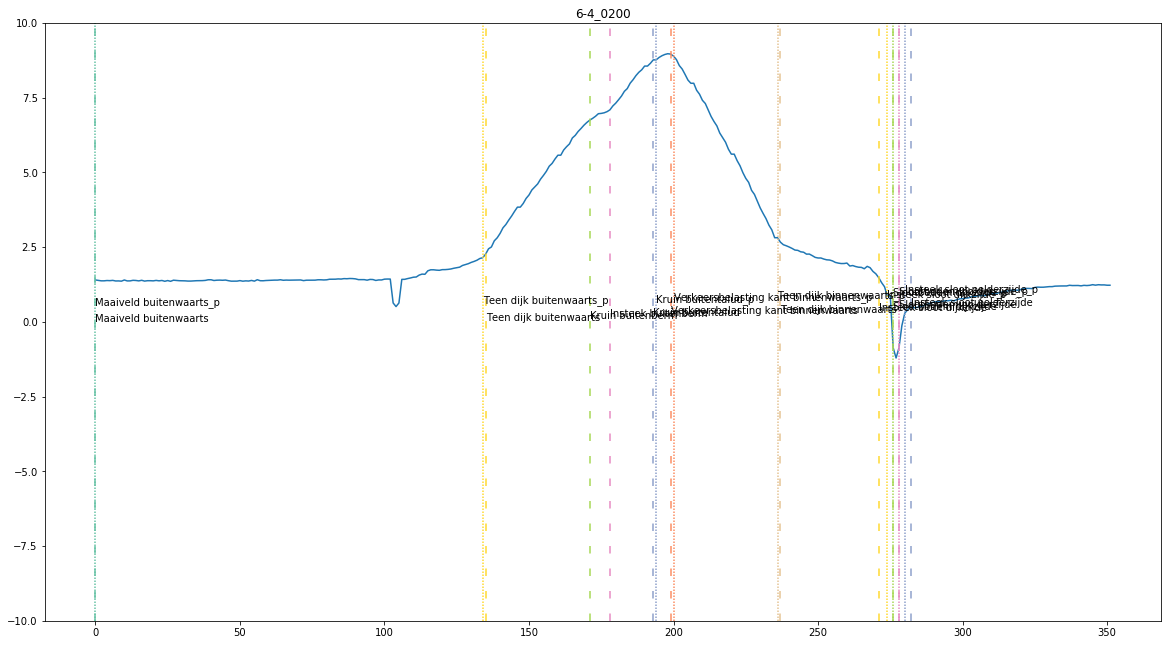

In [62]:
model.eval()
cmap = sns.color_palette("Set2",len(set(class_dict.values())))
# cmap = sns.color_palette("Set2",21)

key = np.random.choice(list(profile_dict.keys()))
# profile_dict[key]
random_sample_x = profile_dict[key]['profile']
random_sample_y = profile_dict[key]['label']
# location_name = location_list[idx]
fig, ax = plt.subplots(figsize=(20,11))
plt.title(key)
sns.lineplot(data=scaler.inverse_transform(random_sample_x.reshape(-1,1)).reshape(-1))
ax.set_ylim(top=10, bottom=-10)
label_height = 0
label_height_distance = np.max(random_sample_x)/21

# print(random_sample_y)

shp = random_sample_x.shape
# print(shp)
fake_batch = torch.tensor(random_sample_x.reshape(1, 1, shp[0])).to(device)
# print(fake_batch)

outputs = model(fake_batch)
flat_output = torch.argmax(outputs, dim=1).cpu()
pred = flat_output[0].numpy()

# print(pred)

prev_class_n = 999
for index, class_n in enumerate(random_sample_y):
    if class_n == 0:
        continue
    if class_n != prev_class_n:
        plt.axvline(index, 0,5, color=cmap[class_n], linestyle=(0,(5,10))) # loose dashes
        plt.text(index, label_height, inverse_class_dict[class_n], rotation=0)
        label_height += label_height_distance
        prev_class_n = class_n

used_classes = []
prev_class_n = 999
for index, class_n in enumerate(pred):
    if class_n == 0 or class_n in used_classes:
        continue
    if class_n != prev_class_n:
        plt.axvline(index, 0,5, color=cmap[class_n], linestyle=(0,(1,1))) # small dots
        plt.text(index, label_height, inverse_class_dict[class_n] + "_p", rotation=0)
        label_height += label_height_distance
        used_classes.append(prev_class_n)
        prev_class_n = class_n

In [118]:
# profiles_to_predict[list(profiles_to_predict.keys())[10]]
header = ["LOCATIONID", 
          "X_Maaiveld binnenwaarts",
          "Y_Maaiveld binnenwaarts",
          "Z_Maaiveld binnenwaarts",
          "X_Insteek sloot polderzijde",
          "Y_Insteek sloot polderzijde",
          "Z_Insteek sloot polderzijde",
          "X_Slootbodem polderzijde",
          "Y_Slootbodem polderzijde",
          "Z_Slootbodem polderzijde",
          "X_Slootbodem dijkzijde",
          "Y_Slootbodem dijkzijde",
          "Z_Slootbodem dijkzijde",
          "X_Insteek sloot dijkzijde",
          "Y_Insteek sloot dijkzijde",
          "Z_Insteek sloot dijkzijde",
          "X_Teen dijk binnenwaarts",
          "Y_Teen dijk binnenwaarts",
          "Z_Teen dijk binnenwaarts",
          "X_Kruin binnenberm",
          "Y_Kruin binnenberm",
          "Z_Kruin binnenberm",
          "X_Insteek binnenberm",
          "Y_Insteek binnenberm",
          "Z_Insteek binnenberm",
          "X_Kruin binnentalud",
          "Y_Kruin binnentalud",
          "Z_Kruin binnentalud",
          "X_Verkeersbelasting kant binnenwaarts",
          "Y_Verkeersbelasting kant binnenwaarts",
          "Z_Verkeersbelasting kant binnenwaarts",
          "X_Verkeersbelasting kant buitenwaarts",
          "Y_Verkeersbelasting kant buitenwaarts",
          "Z_Verkeersbelasting kant buitenwaarts",
          "X_Kruin buitentalud",
          "Y_Kruin buitentalud",
          "Z_Kruin buitentalud",
          "X_Insteek buitenberm",
          "Y_Insteek buitenberm",
          "Z_Insteek buitenberm",
          "X_Kruin buitenberm",
          "Y_Kruin buitenberm",
          "Z_Kruin buitenberm",
          "X_Teen dijk buitenwaarts",
          "Y_Teen dijk buitenwaarts",
          "Z_Teen dijk buitenwaarts",
          "X_Insteek geul",
          "Y_Insteek geul",
          "Z_Insteek geul",
          "X_Teen geul",
          "Y_Teen geul",
          "Z_Teen geul",
          "X_Maaiveld buitenwaarts",
          "Y_Maaiveld buitenwaarts",
          "Z_Maaiveld buitenwaarts"
         ]

# surfaceline_df.head()

In [122]:
# CALCULATE RESULTS AND WRITE TO CLICKTOOL FORMAT
profiles_to_predict = reg_keringen_profiles.copy()

surfaceline_df = pd.DataFrame([], columns=header, index=list(profiles_to_predict.keys()))

# a = pd.DataFrame([], columns=header, index=range(len(profiles_to_predict)))

for key, value in profiles_to_predict.items():
    fake_batch = torch.tensor(value['profile'].reshape(1, 1, value['profile'].shape[-1])).to(device)
    # print(fake_batch)
#     print(key)

    outputs = model(fake_batch)
    flat_output = torch.argmax(outputs, dim=1).cpu()
    pred = flat_output[0].numpy()
    
    pred_tmp = np.zeros(pred.shape[0] + 1)
    pred_tmp[:pred.shape[0]] = pred
    pred = pred_tmp

    
    stripped_pred = np.zeros(pred.shape)
    
    used_classes = []
    prev_class_n = 999
    
    for index, class_n in enumerate(pred):
        if class_n == 0 or class_n in used_classes:
            continue
        if class_n != prev_class_n:
            stripped_pred[index] = class_n
            used_classes.append(prev_class_n)
            prev_class_n = class_n

    shp = len(surfaceline_dict[key])
    surfaceline_dict[key] = surfaceline_dict[key] + [surfaceline_dict[key][-1]] * 200
#     print(surfaceline_dict[key])
    
    for i, points in enumerate(stripped_pred):
        if points != 0:
            
            class_name = inverse_class_dict[points]
            try:
                surfaceline_df.loc[key]["X_" + class_name] = surfaceline_dict[key][i][0]
                surfaceline_df.loc[key]["Y_" + class_name] = surfaceline_dict[key][i][1]
                surfaceline_df.loc[key]["Z_" + class_name] = surfaceline_dict[key][i][2]
            except:
                print("error in ", class_name)
            
    profiles_to_predict[key]['prediction'] = pred
    
#     sns.lineplot(data=pred, label="pred")
#     sns.lineplot(data=value['label'], label='true')
#     plt.show()
surfaceline_df['LOCATIONID'] = surfaceline_df.index
surfaceline_df = surfaceline_df.fillna(-1)

In [125]:
# surfaceline_df.loc["12-2_201"]
# print(surfaceline_df.index.values[0])
# surfaceline_df.iloc[0]
surfaceline_df.head()
surfaceline_df.to_csv('test_points_12-2.csv', index=False, sep=';')

In [119]:
# surfaceline_df = surfaceline_df.fillna(-1)

# surfaceline_dict[list(surfaceline_dict.keys())[0]]
# reg_keringen_profiles['12-2_3']['label']